In [78]:
from fastbook import *
from fastai.vision.widgets import *

In [79]:
key = os.environ.get('AZURE_SEARCH_KEY', '092ccf676dcc48ceab05a9e499b3c8fb')

In [80]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [81]:
results = search_images_bing(key, 'pug')
ims = results.attrgot('content_url')
len(ims)

150

In [82]:
ims = ['https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg']

In [83]:
dest = 'images/pug.jpg'
download_url(ims[0], dest)

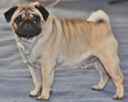

In [84]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [86]:
dog_types = 'pug', 'german', 'dachshund', 'komondor'
path = Path('dogs')

In [87]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('content_url'))

In [88]:
fns = get_image_files(path)
fns

(#598) [Path('dogs/dachshund/00000038.jpg'),Path('dogs/dachshund/00000010.jpg'),Path('dogs/dachshund/00000004.jpg'),Path('dogs/dachshund/00000005.jpg'),Path('dogs/dachshund/00000011.jpg'),Path('dogs/dachshund/00000039.jpg'),Path('dogs/dachshund/00000007.jpg'),Path('dogs/dachshund/00000013.jpg'),Path('dogs/dachshund/00000012.jpg'),Path('dogs/dachshund/00000006.jpg')...]

In [89]:
failed = verify_images(fns)
failed

(#65) [Path('dogs/dachshund/00000039.jpg'),Path('dogs/dachshund/00000012.jpg'),Path('dogs/dachshund/00000006.jpg'),Path('dogs/dachshund/00000098.jpeg'),Path('dogs/dachshund/00000001.JPG'),Path('dogs/dachshund/00000029.JPG'),Path('dogs/dachshund/00000107.jpg'),Path('dogs/dachshund/00000113.jpg'),Path('dogs/dachshund/00000072.jpg'),Path('dogs/dachshund/00000112.jpg')...]

In [90]:
failed.map(Path.unlink);

In [95]:
dogs = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128))

In [96]:
dls = dogs.dataloaders(path)

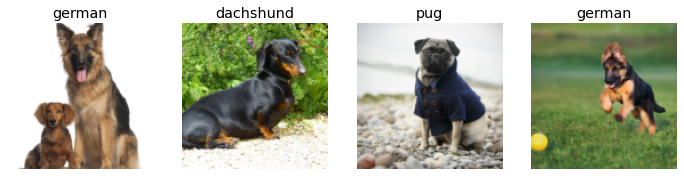

In [97]:
dls.valid.show_batch(max_n=4, nrows = 1)

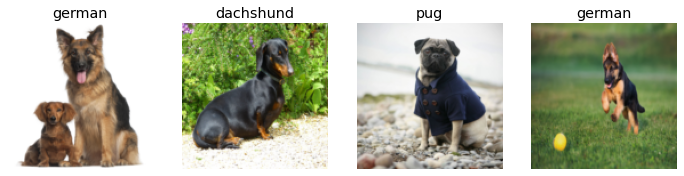

In [98]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows = 1)

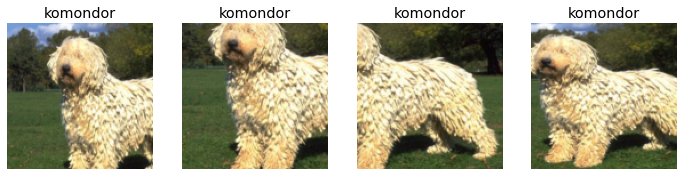

In [99]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1, unique = True)

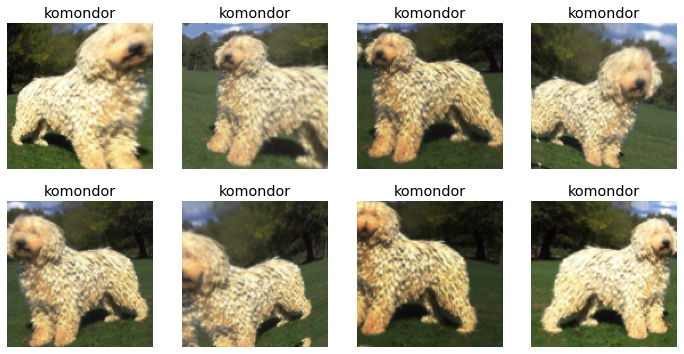

In [100]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult = 2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [102]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [103]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.811091,0.298280,0.075472,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.133042,0.209597,0.066038,01:18
1,0.101528,0.150523,0.047170,01:25
2,0.069632,0.126499,0.047170,01:22
3,0.053576,0.128728,0.047170,01:19


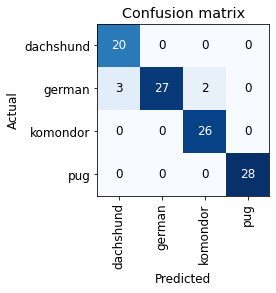

In [104]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

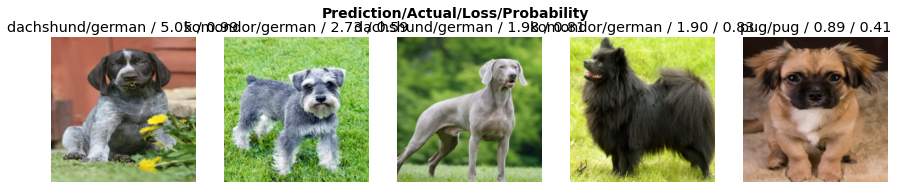

In [105]:
interp.plot_top_losses(5, nrows = 1)

In [106]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [57]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [58]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)